In [1]:
#external stuff
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import numpy as np
import math
import mahotas
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
import traceback
from uuid import uuid4 as unique_identifier
import random
import os
from time import perf_counter
from glob import glob
import pandas as pd
from scipy.optimize import linear_sum_assignment

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm

In [2]:
#internal stuff
from contour_impl import do_contour_create, do_contour_compare
from imageprocessing import maybetogray,maybetocolor, image_preprocess, canny, recenter
from aberrations import aberrations

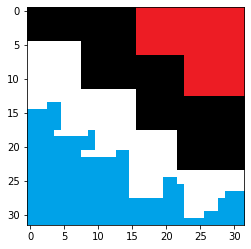

In [3]:
# load some test images
img_files=["stairtest.png","stairtest2.png","cornertest.png","cornertest2.png","cornertest3.png","cornertest4.png","tdl.png","tdl2.png","tokyo.png","tokyo2.png"]
test_images=[cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB) for iname in img_files]
plt.imshow(test_images[0])

In [4]:
def log(kwargs,message):
    if 'log' in kwargs:
        if 'info' in kwargs:
            message['info']=kwargs['info']
        if 'type' in message and message['type']=='Error':
            message['traceback']=traceback.format_exc()
        kwargs['log'] += [message]

        
# each method is a triple of (name, create, compare),
# where
# name: describes the name of the method,
# create: creates a descriptor for a given image
# compare: returns a number indicating the similarity of two images
# each method naturally works on either color or black and white images,
# however we have the adapters grayto3 and gray which turn grayscale images into
# 3 channel images, and color images to grayscale respectively, so everything should work
# with either type of image.

# from the timm library we load multiple neural networks to use as image descriptors
timm_names=['cspdarknet53',
            'tf_efficientnetv2_l',
            'resnet50',
            'ecaresnetlight',
            'mixnet_s',
            'res2next50',
            'vit_small_r26_s32_224',
            'wide_resnet50_2']
# given a model name, load the model and return the method triple
def make_timm_method(modelname=timm_names[0], cuda=False):
    model = timm.create_model(modelname,pretrained=True,num_classes=0)
    if cuda:
        model = model.cuda()
    config = resolve_data_config({},model=model)
    transform = create_transform(**config)
    topil=transforms.ToPILImage()
    def create(img,**kwargs):
        try:
            img=maybetocolor(img)
            timg=topil(img)
            timg=transform(timg).unsqueeze(0)
            if cuda:
                timg=timg.cuda()
            res=model(timg).squeeze().detach()
            if cuda:
                res=res.cpu()
            return res.numpy()
        except:
            log(kwargs,{'type':'Error', 'method':'Timm_'+modelname, 'fn':'create'})
            return None
    def compare(v1,v2,**kwargs):
        try:
            return np.dot(v1,v2)
        except:
            log(kwargs,{'type':'Error', 'method':'Timm_'+modelname, 'fn':'compare'})
            
    return {"name":'Timm_'+modelname, "create":create, "compare":compare}
        
# neural and small neural work on color images
def make_neural_method():
    # Load the pretrained model
    model = models.resnet18(pretrained=True)
    #strip the final layer to get a feature vector
    model = nn.Sequential(*list(model.children())[:-1])  
    # Set model to evaluation mode
    model.eval()

    def create(img,**kwargs):
        try:
            img=maybetocolor(img)
            scaler = transforms.Resize((224, 224))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            to_tensor = transforms.ToTensor()
            pillize = transforms.ToPILImage()
            loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
            l_img = loader(img)
            t_img = Variable(l_img).unsqueeze(0)
            f_vec = model(t_img).squeeze()
            n_vec = f_vec.detach().numpy()
            n_vec = n_vec / np.linalg.norm(n_vec)
            return n_vec
        except:
            log(kwargs,{'type':'Error', 'method':'Neural', 'fn':'create'})
            return None

    def compare(v1, v2,**kwargs):
        try:
            return np.dot(v1, v2)
        except:
            log(kwargs,{'type':'Error', 'method':'Neural', 'fn':'compare'})
            return None   
        
    return {"name":"Neural", "create":create, "compare":compare}

def make_small_neural_method():
    class IconEmbeddingNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.convnet = nn.Sequential(
                nn.Conv2d(3, 32, 5),
                nn.PReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(32, 64, 5),
                nn.PReLU(),
                nn.MaxPool2d(2, stride=2))
            self.fc = nn.Sequential(
                nn.Linear(64 * 4 * 4, 256),
                nn.PReLU(),
                nn.Linear(256, 256),
                nn.PReLU(),
                nn.Linear(256, 8)
                )
        def forward(self, x):
            output = self.convnet(x)
            output = output.view(output.size()[0], -1)
            output = self.fc(output)
            return output

        def get_embedding(self, x):
            return self.forward(x)
        
    model = IconEmbeddingNet()
    model.load_state_dict(torch.load("models/IconEmbeddingNet.pt"))
    model.eval()
    
    def create(img,**kwargs):
        try:
            img=maybetocolor(img)
            scaler = transforms.Resize((28, 28))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            to_tensor = transforms.ToTensor()
            pillize = transforms.ToPILImage()
            loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
            l_img = loader(img)
            t_img = Variable(l_img).unsqueeze(0)
            f_vec = model(t_img).squeeze()
            n_vec = f_vec.detach().numpy()
            return n_vec
        except:
            log(kwargs,{'type':'Error', 'method':'Small_Neural', 'fn':'create'})
            return None

    def compare(v1, v2,**kwargs):
        try:
            sim = 100.0/(np.linalg.norm(v1-v2)+1)
            return sim
        except:
            log(kwargs,{'type':'Error', 'method':'Small_Neural', 'fn':'compare'})
            return None
    
    return {"name":"Small_Neural", "create":create, "compare":compare}


def make_orb_method():
    orb = cv2.ORB_create()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    def create(img, **kwargs):
        try:
            img = maybetogray(img)
            # old image preprocessing
            # this will be moved to the more general framework
            img = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

            # find the keypoints and descriptors with orb
            kp1, des1 = orb.detectAndCompute(img,None)
            if len(kp1) < 2:
                des1 = None
            return des1
        except:
            log(kwargs,{'type':'Error', 'method':'Orb', 'fn':'create'})
            return None

    def compare(img_kp1, img_kp2, **kwargs):
        try:
            matches = matcher.match(img_kp1,img_kp2)
            score = len(matches)
            return score
        except:
            log(kwargs,{'type':'Error', 'method':'Orb', 'fn':'compare'})
            return 0
        
    return {"name":"Orb", "create":create, "compare":compare}

def make_zernike_method():
    # image preprocessing
    def zcenter(img):
        _, _, min_x, min_y, max_x, max_y, edges1 = image_preprocess(img) 
        edges2 = edges1[min_y:max_y+1, min_x:max_x+1]
        edges2 = cv2.resize(edges2, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        return edges2
    def create(img, **kwargs):
        try:
            img = maybetogray(img)
            #zcenter is the image preprocessing code that was here before,
            #but zernike_moments is the real functional part of the method
            # this will be moved to the more general framework
            edges2=zcenter(img)
            zernike = mahotas.features.zernike_moments(edges2, 16)  
            return normalize(zernike[:,np.newaxis], axis=0).ravel()
        except:
            log(kwargs,{'type':'Error', 'method':'Zernike', 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            return np.dot(x,y)
        except:
            log(kwargs,{'type':'Error', 'method':'Zernike', 'fn':'compare'})
            return 0
    return {"name":"Zernike", "create":create, "compare":compare}

def make_center_zernike_method():
    def create(img, **kwargs):
        try:
            img = recenter(img)
            img = maybetogray(img)
           
            zernike = mahotas.features.zernike_moments(img, 16)  
            return normalize(zernike[:,np.newaxis], axis=0).ravel()
        except:
            log(kwargs,{'type':'Error', 'method':'CenterZernike', 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            return np.dot(x,y)
        except:
            log(kwargs,{'type':'Error', 'method':'CenterZernike', 'fn':'compare'})
            return 0
    return {"name":"CenterZernike", "create":create, "compare":compare}

def make_color_zernike_method():
    def create(img, **kwargs):
        try:
            img = recenter(img)
            gimg = maybetogray(img)
           
            zernikes = np.array([mahotas.features.zernike_moments(gimg, 16)]+[mahotas.features.zernike_moments(img[:,:,i], 16) for i in range(img.shape[-1])])
            zernikes = normalize(zernikes, axis=1)
            return zernikes.ravel()/4
        except:
            log(kwargs,{'type':'Error', 'method':'ColorZernike', 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            return np.dot(x,y)
        except:
            log(kwargs,{'type':'Error', 'method':'ColorZernike', 'fn':'compare'})
            return 0
    return {"name":"ColorZernike", "create":create, "compare":compare}

def make_contour_method(fractions=[.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]):
    def create(img, **kwargs):
        try:
            return do_contour_create(img,fractions,**kwargs)
        except:
            log(kwargs,{'type':'Error', 'method':'Contour', 'fn':'create'})
            return None
        
    def compare(query1, query2, error=0.1, **kwargs):
        try:
            return do_contour_compare(query1, query2, fractions,error,**kwargs)
        except:
            log(kwargs,{'type':'Error', 'method':'Contour', 'fn':'compare'})
            return 0
    
    return {"name":"Contour", "create":create, "compare":compare}

our_methods=[make_neural_method, make_small_neural_method, make_zernike_method, make_center_zernike_method, make_color_zernike_method, make_orb_method, make_contour_method]
made_timms = [make_timm_method(i) for i in timm_names]
def method_split_hungarian(method, splitter):
    def create(img, **kwargs):
        try:
            imgs = splitter(img, **kwargs)
            #print('creating ',len(imgs))
            return [method["create"](i, **kwargs) for i in imgs]
        except:
            log(kwargs,{'type':'Error', 'method':'SplitWrapped_'+method["name"], 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            #print('xlen ',len(x))
            #print('ylen ',len(y))
            vals = np.array([[method["compare"](i,j,**kwargs) for i in x] for j in y])
            #print(vals)
            rows, cols = linear_sum_assignment(-vals)
            if len(rows)==0:
                print('zero comp ',rows,cols)
                #a=[]
                #a.lower()
                return 0
            x=vals[rows,cols].sum()/len(rows)
            #print('comparing ',x)
            return x
        except:
            log(kwargs,{'type':'Error', 'method':'SplitWrapped_'+method["name"], 'fn':'compare'})
            return 0
    return {"name":'SplitWrapped_'+method["name"], "create":create, "compare":compare}
def method_presplit_hungarian(method, splitter):
    def create(imgs, **kwargs):
        try:
            return [method["create"](i, **kwargs) for i in imgs]
        except:
            log(kwargs,{'type':'Error', 'method':'SplitWrapped_'+method["name"], 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            vals = np.array([[method["compare"](i,j,**kwargs) for i in x] for j in y])
            rows, cols = linear_sum_assignment(vals)
            if len(rows==0):
                print("divide by zero incoming")
            return vals[rows,cols].sum()/len(rows)
        except:
            log(kwargs,{'type':'Error', 'method':'SplitWrapped_'+method["name"], 'fn':'compare'})
            return 0
    return {"name":'SplitWrapped_'+method["name"], "create":create, "compare":compare}
class database:
    def __init__(self, method, images=[], preprocess=None, **kwargs):
        self.name = method["name"]
        self.create = method["create"]
        self.compare = method["compare"]
        self.preprocess = preprocess[1] if preprocess is not None else noop
        self.preprocessing_name = preprocess[0] if preprocess is not None else "None"
        self.db = {i:self.create(self.preprocess(images[i]), **kwargs) for i in range(len(images))}
        
    def find(self, img, candidates=None, others=[], should_sort=True, **kwargs):
        imgq = self.create(self.preprocess(img), **kwargs)
        candidates = candidates or self.db.keys()
        tmp_db = {-i:self.create(others[i], **kwargs) for i in range(len(others))}
        results = [(i, self.compare(imgq, self.db[i], **kwargs)) for i in candidates]
        tmp_results = [(i, self.compare(imgq, tmp_db[i], **kwargs)) for i in tmp_db.keys()]
        if should_sort:
            return sorted(results+tmp_results, key=lambda x: -x[1])
        else:
            return results+tmp_results

C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\torchvision\transforms\transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[]


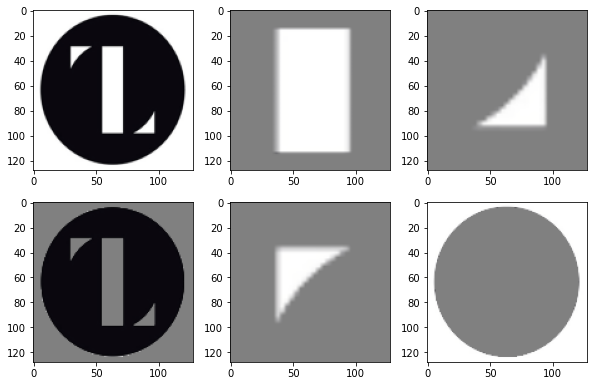

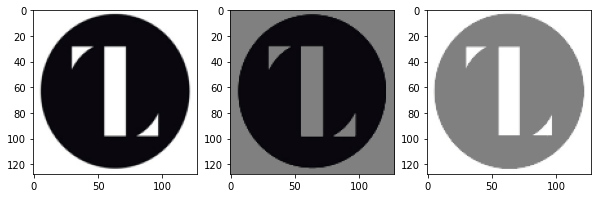

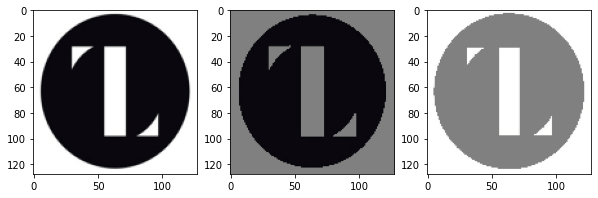

In [5]:
# image manipulation
# for all the different methods we first make a copy of the image just in case
# something decides to modify the original.
# Thank God for gigabytes of RAM
def stack(funcs):
    #compose several image manipulations 
    def nf(img):
        img=img[:]
        for f in funcs:
            img=f(img)
        return img
    return nf
def noop(img):
    return img
def color_reduce_kmeans(img, n_colors=8):
    img=img[:]
    h,w,c=img.shape
    fimg=np.clip(img.reshape(-1,3)/255,0.05,0.95)
    km=KMeans(n_clusters=n_colors,random_state=0).fit(fimg)
    means=np.clip(km.cluster_centers_,0.0,1.0)
    labels=km.predict(fimg)
    return (means[labels].reshape(img.shape)*255).astype(np.uint8)

def smooth_median(img,ks=5,n=2):
    img=img[:]
    for i in range(n):
        img=cv2.medianBlur(img,ks)
    return img
def std_size(img):
    img=img[:]
    return cv2.resize(img,(128,128),interpolation=cv2.INTER_AREA)

def big_size(img):
    return cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

# segmentation
def scast2(x,r):
        xpad=np.pad(x,[[0,0],[0,1]],mode="constant", constant_values=r)
        return xpad/np.linalg.norm(x,axis=1,keepdims=True)
def genkeys(n,d):
    r=np.random.normal(size=(n,d))
    r=r/np.linalg.norm(r,axis=1,keepdims=True)
    r=np.pad(r,[[1,0],[0,1]],mode="constant",constant_values=0)
    r[0,-1]=1
    return r
def meancolor(img,b):
    return np.floor(np.sum(img[b],(0)) / (0.01+np.sum(b))).astype(np.uint8)
def clamp(x, m,M):
    if x < m:
        return m
    if x > M:
        return M
    return x
def gsb(s,margin=10):
    h,w=s.shape
    x,y=np.where(s)
    x1=clamp(x.min()-margin,0,w)
    y1=clamp(y.min()-margin,0,h)
    x2=clamp(x.max()+margin,0,w)
    y2=clamp(y.max()+margin,0,h)
    return x1,y1,x2,y2
    #return x.min()-margin, y.min()-margin, x.max()+margin, y.max()+margin
def cropresize(img,b,bg=None,**kwargs):
    try:
        x1,y1,x2,y2=gsb(b)
        if bg is not None:
            img=img.copy()
            img[b!=True]=bg
        diff = max(x2-x1, y2-y1)
        xc = (x2+x1)/2
        yc = (y2+y1)/2
        return cv2.resize(img[x1:x2,y1:y2,:],img.shape[:-1])
    except:
        log(kwargs,{'type':'Error', 'method':'Segmentation', 'fn':'cropresize'})
        return None
def segment_labels(img,labels,bg=None,rejection=0.0,**kwargs):
    ulabels=np.unique(labels)
    h,w=labels.shape
    total=h*w
    masks=[labels==i for i in ulabels]
    # throw away any masks that cover less than 'rejection' percent of the image
    masks=[m for m in masks if np.sum(m) >= (rejection*total)]
    segs= [cropresize(img,b,bg,**kwargs) for b in masks]
    return [s for s in segs if s is not None]

def segment_agglomerative(img,n_clusters=5,**kwargs):
    feats = img.reshape(-1,3)
    connectivity=grid_to_graph(*img.shape[:2])
    clustering=AgglomerativeClustering(n_clusters=n_clusters,connectivity=connectivity)
    clustering.fit(feats)
    return segment_labels(img,clustering.labels_.reshape(img.shape[:2]),**kwargs)

def segment_kmeans(img, n_colors=10, n_shapes=10,bg=None,**kwargs):
    img=img[:]
    h,w,c=img.shape
    fimg=np.clip(img.reshape(-1,3)/255,0.05,0.95)
    km=KMeans(n_clusters=n_colors,random_state=0).fit(fimg)
    means=np.clip(km.cluster_centers_,0.0,1.0)
    labels=np.array(km.predict(fimg)).reshape(*img.shape[:-1])
    return segment_labels(img,labels,bg=bg,**kwargs)

def segment_colors(img, threshold=.98,bg=None,**kwargs):
    # image is assumed to be HxWx3
    v=np.reshape(img,(-1,3))/255
    n=scast2(v-np.mean(v,0),0.01)
    r=genkeys(200,3)

    ids=np.argmax(n.dot(r.transpose()), axis=1)
    uids=np.unique(ids)
    w=np.array([np.sum(ids==i) for i in uids])/ids.size
    ws=np.argsort(-w)
    sids=uids[ws]
    csm=np.cumsum(w[ws])
    iids=np.array([sids[i] for i in range(1,len(sids)) if csm[i-1]<threshold])
    rids=ids.reshape(img.shape[:-1])
    return segment_labels(img,rids,bg=bg,**kwargs)

def segment_noop(imgs, **kwargs):
    # if the image set is already given as the decompositions
    return imgs

def plot_many(imgs,n_c=3):
    # convenience function to plot many images
    n_r = (len(imgs)//n_c)+1
    cc=1
    fig=plt.figure(figsize=(10,10))
    for i in imgs:
        fig.add_subplot(n_r,n_c,cc)
        plt.imshow(i)
        cc+=1
        
processing_pipelines = [
    None,
    ("color_reduce_kmeans", color_reduce_kmeans),
    ("smooth_median", smooth_median),
    ("recenter", recenter),
    ("recenter, reduce, smooth", stack([recenter, color_reduce_kmeans, smooth_median]))
]
        
#plt.imshow(smooth_median(test_images[8],3,1))
#plt.imshow(smooth_median(color_reduce_kmeans(test_images[8],2),3,1))
rimg=std_size(test_images[8])
#rimg=color_reduce_kmeans(rimg,4)
#rimg=smooth_median(rimg,5,2)
#plt.imshow(rimg)
l=[]
segs=segment_agglomerative(rimg,log=l,bg=[128,128,128],rejection=0.001)
plot_many([rimg]+segs)
segs=segment_colors(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)
segs=segment_kmeans(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)
print(l)
#plt.imshow(smooth_median(color_reduce_kmeans(images[0])))

In [6]:
# how to run your images
def chunks(x, n=100):
    for i in range(0, len(x), n):
        yield x[i:i+n]
def run(dbs,images,aberrations,candidates=None,logdir="Logs",report_every=10):
    print("starting")
    if not os.path.exists("Logs"):
        os.mkdir("Logs")
    if not os.path.exists("Logs/"+logdir):
        os.mkdir("Logs/"+logdir)
    candidates=candidates or [i for i in range(len(images))]
    results={}
    imgs_so_far=0
    for img_idx in candidates:
        print("nimg")
        imgs_so_far+=1
        if imgs_so_far % report_every == 0:
            print(imgs_so_far)
        cimg=images[img_idx][:]
        for aber in aberrations:
            qimg=aber(cimg) if aber is not None else cimg
            for d in dbs:
                start_time=perf_counter()
                xl = d.find(qimg)
                rank=0
                for hit in xl:
                    rank+=1
                    if hit[0]==img_idx:
                        break
                duration = perf_counter() - start_time
                results.setdefault("aberration",[]).append(aber.__name__ if aber is not None else "ab_id")
                results.setdefault("method",[]).append(d.name)
                results.setdefault("preprocess",[]).append(d.preprocessing_name)
                results.setdefault("rank",[]).append(rank)
                results.setdefault("time",[]).append(duration)
    # save everything to file and return the dataframes
    results_pd = pd.DataFrame(data=results)
    log_num = len(glob("Logs/"+logdir+"/*")) + 1
    results_pd.to_csv("Logs/"+logdir+'/results_'+str(log_num)+'.csv', index = None, header=True)
    print("logging")
    return results_pd

def run_in_chunks(dbs,images,aberrations,chunksize=100,logdir="Logs"):
    candidates = [i for i in range(len(images))]
    random.shuffle(candidates)
    for chunk_num, candidate_chunk in enumerate(chunks(candidates,chunksize)):
        print("Chunk: " + str(chunk_num+1))
        run(dbs,images,aberrations,candidates=candidate_chunk,logdir=logdir)

In [7]:
# how to run your images 2, electric boogaloo
def make_aberimgs(imgs,abers):
    res=[]
    for idx,im in enumerate(imgs):
        for a in abers:
            res+=[[idx,a(im) if a is not None else im, a.__name__ if a is not None else "ab_id"]]
    return res
def run(db,aber_images,logdir="Logs",report_every=10):
    print("starting")
    if not os.path.exists("Logs"):
        os.mkdir("Logs")
    if not os.path.exists("Logs/"+logdir):
        os.mkdir("Logs/"+logdir)
    candidates= [i for i in range(len(aber_images))]
    results={}
    imgs_so_far=0
    for idx,aberimg,abername in aber_images:
        imgs_so_far+=1
        if imgs_so_far % report_every == 0:
            print(imgs_so_far, "img idx ", idx)
        
        start_time=perf_counter()
        xl = db.find(aberimg)
        rank=0
        for hit in xl:
            rank+=1
            if hit[0]==idx:
                break
        duration = perf_counter() - start_time
        results.setdefault("aberration",[]).append(abername)
        results.setdefault("method",[]).append(db.name)
        results.setdefault("preprocess",[]).append(db.preprocessing_name)
        results.setdefault("rank",[]).append(rank)
        results.setdefault("time",[]).append(duration)
    # save everything to file and return the dataframes
    results_pd = pd.DataFrame(data=results)
    log_num = len(glob("Logs/"+logdir+"/*")) + 1
    results_pd.to_csv("Logs/"+logdir+'/results_'+str(log_num)+'.csv', index = None, header=True)
    print("logging")
    return results_pd

def run_all(methods,images,aberrations,pipelines,logdir="Logs",loglist=[]):
    aberimgs=make_aberimgs(images,aberrations)
    for m in methods:
        print('starting new method')
        for p in pipelines:
            print('making db')
            db=database(m, images, log=loglist, preprocess=p)
            print('db made, running')
            run(db,aberimgs,logdir=logdir)
            print('ran')
    if loglist != []:
        print("we had errors please check the return value")
    return loglist

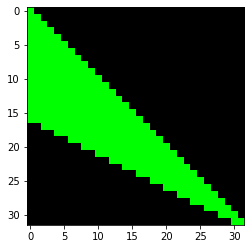

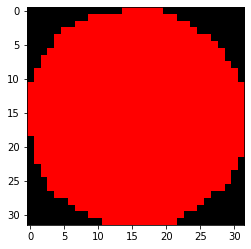

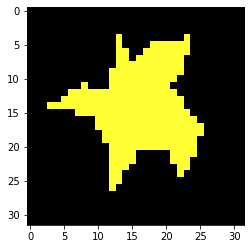

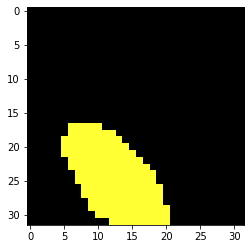

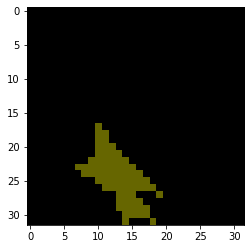

In [8]:
from PIL import Image, ImageDraw
from math import sin,cos
def draw_poly(dc,poly, scale=1, **kwargs):
    coords = (poly*scale).astype(int)
    dc.polygon([tuple(i) for i in coords],**kwargs)
polys=[# wedge
       [[0,0], [0,0.5], [1,1]],
       # circle
       [[0.5+cos(x*6.14/20)/2,0.5+sin(x*6.14/20)/2] for x in range(20)],
       # randomly perturbed circle
       [[0.5+cos(x*6.14/20)*np.random.uniform(0.2,1.0)/2,0.5+sin(x*6.14/20)*np.random.uniform(0.2,1.0)/2] for x in range(20)],
       # squished circle
       [[0.43889485, 1.01199527],
           [0.50584096, 1.03654858],
           [0.56339267, 1.03823472],
           [0.60616826, 1.01689601],
           [0.63016773, 0.97452786],
           [0.63314687, 0.91509216],
           [0.61482709, 0.8441468 ],
           [0.5769215 , 0.76832597],
           [0.52297469, 0.69471975],
           [0.45803129, 0.63021113],
           [0.38816421, 0.58083239],
           [0.31990682, 0.551201  ],
           [0.25964192, 0.5440878 ],
           [0.21300497, 0.56015797],
           [0.18435702, 0.59790877],
           [0.17637698, 0.65381007],
           [0.18981107, 0.72263449],
           [0.22340306, 0.79794618],
           [0.27401172, 0.87270266],
           [0.33690458, 0.93991338]],
      # star thing
      [[0.41807544, 0.87534801],
       [0.46415562, 0.98536887],
       [0.53947724, 0.94539019],
       [0.59524502, 1.0083861 ],
       [0.51879522, 0.89930979],
       [0.48691866, 0.83740086],
       [0.6054967 , 0.86355202],
       [0.58552607, 0.83129026],
       [0.41381491, 0.66344889],
       [0.4658818 , 0.68867009],
       [0.38576388, 0.62978679],
       [0.32330981, 0.55634607],
       [0.32094132, 0.70405591],
       [0.32852805, 0.70085152],
       [0.3041241 , 0.72073516],
       [0.28525641, 0.71508238],
       [0.22339421, 0.71973661],
       [0.35555229, 0.82499804],
       [0.33906122, 0.81146125],
       [0.38112243, 0.83347015]]]
polys=[np.array(p) for p in polys]
colors=[[255,255,255], #white
        [255,0,0], #red
        [0,255,0], #green
        [0,0,255], #blue
        [102,0,204], #purple
        [128,128,128], #gray
        [255,153,153], #pink
        [153,153,0], #puke green
        [102,102,0], #camo green
        [255,128,0], #orange
        [204,255,153], #light green
        [255,255,51], #lemon yellow
        [255,255,0], #yellow
       ]
for poly in polys:
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    plt.figure()
    plt.imshow(im)

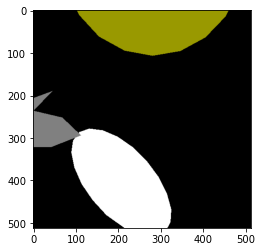

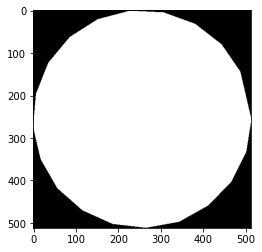

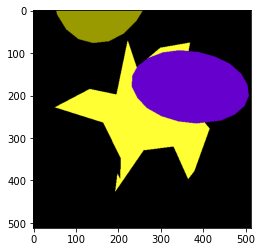

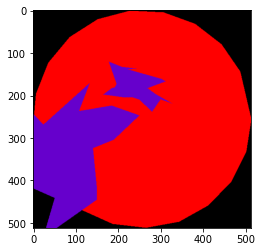

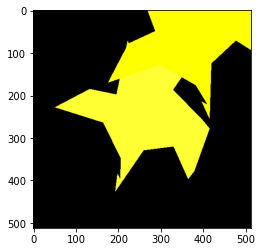

<Figure size 432x288 with 0 Axes>

In [9]:

def draw_and_show_poly(poly, scale=32):
    im=Image.new('RGB', (scale,scale))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=scale,fill="white")
    plt.figure()
    plt.imshow(im)
def create_transform_random():
    mat=np.random.uniform(0,1,(3,3))*0.5
    mat[2,0]=0
    mat[2,1]=0
    mat[2,2]=1
    return mat

def create_transform_identity():
    return np.eye(3,3)

def create_transform_informed(scale=(1.0,1.0), rotation=(0.0,0.0), symmetry=False, transform=(0.0,0.0), heat=0):
    res=np.eye(3)
    scaleness=np.eye(3)*np.random.uniform(*scale)
    res=res.dot(scaleness)
    rotateness=np.random.uniform(*rotation)
    if symmetry:
        rotateness += np.random.choice([0,.25,.5,.75])
    rotatarr=np.array([[ cos(rotateness*6.28), sin(rotateness*6.28), 0],
                         [-sin(rotateness*6.28), cos(rotateness*6.28), 0],
                         [0,0,1]])
    res=res.dot(rotatarr)
    hotness=create_transform_random()*heat
    res=res+(hotness-heat/2)
    res[0,2]=np.random.uniform(*transform)
    res[1,2]=np.random.uniform(*transform)
    return res
    
def transform(tform, points):
    res = np.concatenate([points,np.ones([points.shape[0],1])], axis=1)
    return res.dot(tform.transpose())[:,:2]

def render(dc,scale,tforms, shapes,colors):
    for t,sh,c in zip(tforms, shapes,colors):
        draw_poly(dc,transform(t,sh),scale=scale, fill=c)
        
def render_image_split(scale,tforms,shapes,colors):
    res=[]
    for t,sh,c in zip(tforms, shapes,colors):
        im = Image.new('RGB', (scale,scale))
        dc = ImageDraw.Draw(im)
        draw_poly(dc,transform(t,sh),scale=scale, fill=c)
        res.append(im.copy())
    return res

def render_image(scale,tforms,shapes,colors):
    im = Image.new('RGB', (scale,scale))
    dc = ImageDraw.Draw(im)
    render(dc,scale,tforms,shapes,colors)
    return im
        
def create_random_icon(shapes, colors):
    structure = [create_transform_identity(),
                create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2),
                create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2),]
    colors = [tuple(colors[np.random.choice(len(colors))]),
              tuple(colors[np.random.choice(len(colors))]),
              tuple(colors[np.random.choice(len(colors))])]
    s = [shapes[np.random.choice(len(shapes))],
         shapes[np.random.choice(len(shapes))],
         shapes[np.random.choice(len(shapes))]]
    return structure,colors,s


def make_icon3(shapes, colors):
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    shape1 = shapes[np.random.choice(len(shapes))]
    shape2 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_identity()
    shape2=transform(tform,shape2)
    draw_poly(dc,shape2,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    return im

def make_icon(shapes, colors):
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    shape1 = shapes[np.random.choice(len(shapes))]
    shape2 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2)
    shape2=transform(tform,shape2)
    shape3 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2)
    shape3=transform(tform,shape3)
    draw_poly(dc,shape1,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    draw_poly(dc,shape2,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    draw_poly(dc,shape3,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    return im

def make_icon2(scale,shapes, colors):
    structure,colors,s=create_random_icon(shapes,colors)
    return render_image(scale,structure,s,colors)
for i in range(5):
    plt.imshow(make_icon2(512,polys,colors))
    plt.figure()

In [10]:
synthetic_image_data = [create_random_icon(polys,colors) for _ in range(100)]
print(len(synthetic_image_data))
low_res_renders = [render_image(32,i[0],i[2],i[1]) for i in synthetic_image_data]
high_res_renders = [render_image(512,i[0],i[2],i[1]) for i in synthetic_image_data]

100


In [29]:
high_res_split_renders = [render_image_split(512,i[0],i[2],i[1]) for i in synthetic_image_data]
low_res_split_renders = [render_image_split(32,i[0],i[2],i[1]) for i in synthetic_image_data]

In [72]:
high_res_components=[[np.array(i) for i in j] for j in high_res_split_renders]

In [145]:
image_set_name = "icon100"
logdir = "Logs20220101TEST16"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images = hdf5_file['data']
# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]

#running_images=[np.array(i) for i in low_res_renders[:100]]
running_images=images
#running_images=high_res_components #make sure to use segment_noop with the method combinator
print(len(images))
print("Loading Completed")

#running_methods=[make_timm_method(i,cuda=True) for i in timm_names]+[m() for m in our_methods]
running_methods=[method_split_hungarian(make_small_neural_method(), segment_agglomerative)]
#running_methods=[method_split_hungarian(make_small_neural_method(), segment_colors)]
#running_methods=[make_small_neural_method()]
#running_methods=[method_split_hungarian(make_small_neural_method(), segment_noop)] # make sure to use presplit images with segment noop
print('made it, running')
err=run_all(running_methods, running_images,
            aberrations,
            [None],#processing_pipelines,[processing_pipelines[2]],#
            logdir=logdir)

100
Loading Completed
made it, running
starting new method
making db
db made, running
starting
10 img idx  0
20 img idx  1
30 img idx  2
40 img idx  3
50 img idx  3
60 img idx  4
70 img idx  5
80 img idx  6
90 img idx  6
100 img idx  7
110 img idx  8
120 img idx  9
130 img idx  9
140 img idx  10
150 img idx  11
160 img idx  12
170 img idx  13
180 img idx  13
190 img idx  14
200 img idx  15
210 img idx  16
220 img idx  16
230 img idx  17
240 img idx  18
250 img idx  19
260 img idx  19
270 img idx  20
280 img idx  21
290 img idx  22
300 img idx  23
310 img idx  23
320 img idx  24
330 img idx  25
340 img idx  26
350 img idx  26
360 img idx  27
370 img idx  28
380 img idx  29
390 img idx  29
400 img idx  30
410 img idx  31
420 img idx  32
430 img idx  33
440 img idx  33
450 img idx  34
460 img idx  35
470 img idx  36
480 img idx  36
490 img idx  37
500 img idx  38
510 img idx  39
520 img idx  39
530 img idx  40
540 img idx  41
550 img idx  42
560 img idx  43
570 img idx  43
580 img idx  44

In [146]:
# read logs
logdir = "Logs20220101TEST16"
# Load all the logs into a single dataframe for processing
log_files = glob("Logs/"+logdir+"/*") # these are the logs that we're loading
print(log_files)
joined_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(joined_logs)



['Logs/Logs20220101TEST16\\results_1.csv']
            aberration                     method preprocess  rank      time
0                ab_id  SplitWrapped_Small_Neural       None     1  0.055420
1              ab_line  SplitWrapped_Small_Neural       None     1  0.057437
2            ab_circle  SplitWrapped_Small_Neural       None     1  0.060976
3     ab_rotate_border  SplitWrapped_Small_Neural       None     1  0.057068
4       ab_rotate_safe  SplitWrapped_Small_Neural       None     9  0.081697
...                ...                        ...        ...   ...       ...
1295  ab_affine_border  SplitWrapped_Small_Neural       None     1  0.065442
1296           ab_flip  SplitWrapped_Small_Neural       None     1  0.061925
1297           ab_draw  SplitWrapped_Small_Neural       None     1  0.060837
1298           ab_warp  SplitWrapped_Small_Neural       None     1  0.057895
1299      ab_draw_warp  SplitWrapped_Small_Neural       None     2  0.063035

[1300 rows x 5 columns]


Ranking
['SplitWrapped_Small_Neural']


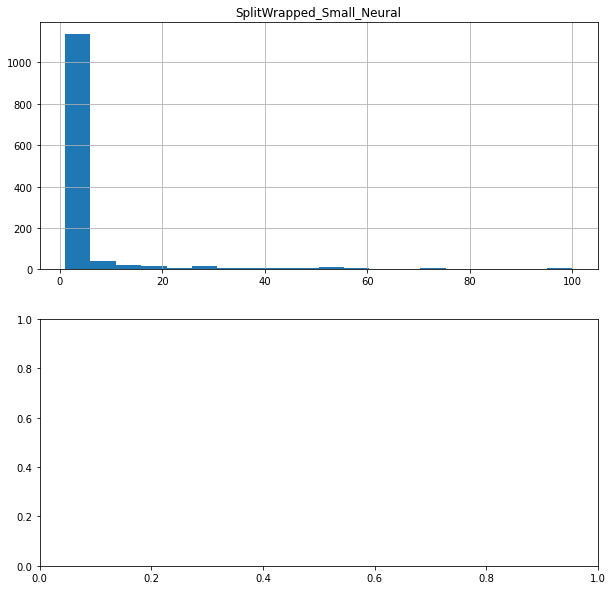

In [147]:
print("Ranking")
mets=joined_logs["method"].unique()
print(mets)
split_logs=joined_logs
ncols=1
nrows=(len(mets)//ncols)+1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    joined_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [16]:
a=[1,2,3]
a.lower()

AttributeError: 'list' object has no attribute 'lower'

0.6392677783966064


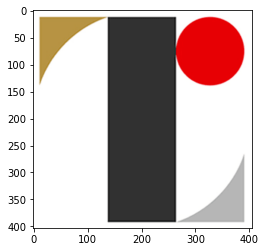

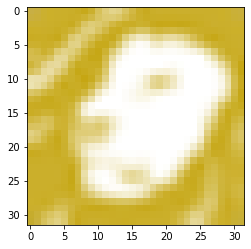

In [130]:
method=make_neural_method()
splitter=segment_agglomerative
# choose the images
cimg1=test_images[-4]
cimg2=images[0]
plt.imshow(cimg1)
plt.figure()
plt.imshow(cimg2)
        
ximgs = splitter(cimg1,rejection=0.001, bg=[128,128,128])
yimgs = splitter(cimg2,rejection=0.001, bg=[128,128,128])
xf=[method['create'](i) for i in ximgs]
yf=[method['create'](i) for i in yimgs]
l=[]
vals = np.array([[method["compare"](i,j,logs=[]) for i in xf] for j in yf])
rows, cols = linear_sum_assignment(-vals)
ret=vals[rows,cols].sum()/len(rows)
print(ret)

In [97]:
vals

array([[45.06047943, 26.28195613, 15.72746791, 62.95748284, 30.58968243],
       [22.41717803, 20.43491845, 14.34609074, 22.8980222 , 35.2560438 ],
       [65.75481971, 24.05428603, 14.98768733, 56.24980345, 30.26314109],
       [58.1504217 , 24.66011169, 15.20119281, 61.74876493, 30.6806784 ],
       [64.57881085, 24.20899774, 15.00771729, 56.26740265, 30.99194371]])

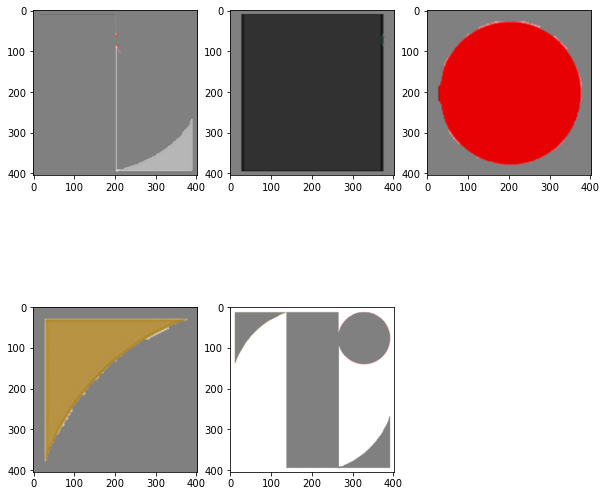

In [89]:
plot_many(ximgs)

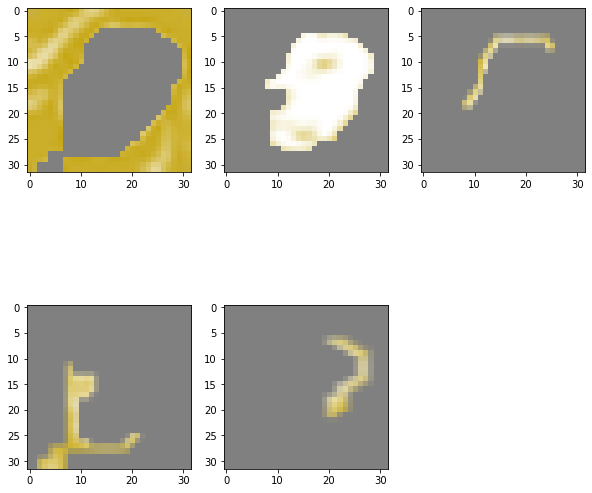

In [90]:
plot_many(yimgs)

61.789311167539516


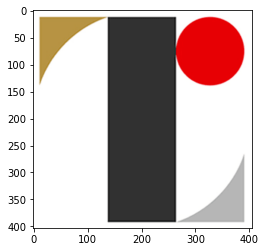

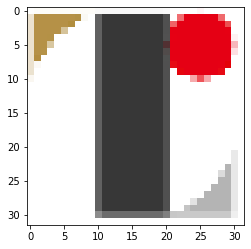

In [163]:
method=make_small_neural_method()#make_small_neural_method()
splitter=segment_agglomerative
# choose the images
cimg1=test_images[-4]
cimg2=test_images[-3]
plt.imshow(cimg1)
plt.figure()
plt.imshow(cimg2)
        
ximgs = splitter(cimg1,rejection=0.001, bg=[128,128,128])
yimgs = splitter(cimg2,rejection=0.001, bg=[128,128,128])
xf=[method['create'](i) for i in ximgs]
yf=[method['create'](i) for i in yimgs]
l=[]
vals = np.array([[method["compare"](i,j,logs=[]) for i in xf] for j in yf])
rows, cols = linear_sum_assignment(-vals)
ret=vals[rows,cols].sum()/len(rows)
print(ret)

In [164]:
vals

array([[26.95897487, 49.0263556 , 19.23175928, 31.43629941, 25.13731025],
       [28.49789926, 22.45265544, 16.10011596, 27.73695056, 81.84704403],
       [22.3057982 , 33.53886728, 30.10651147, 24.68305116, 23.96284645],
       [68.11414569, 24.32504206, 15.35728398, 61.45643765, 28.98850579],
       [86.51020709, 22.93413999, 14.89139372, 47.78619495, 29.39170792]])

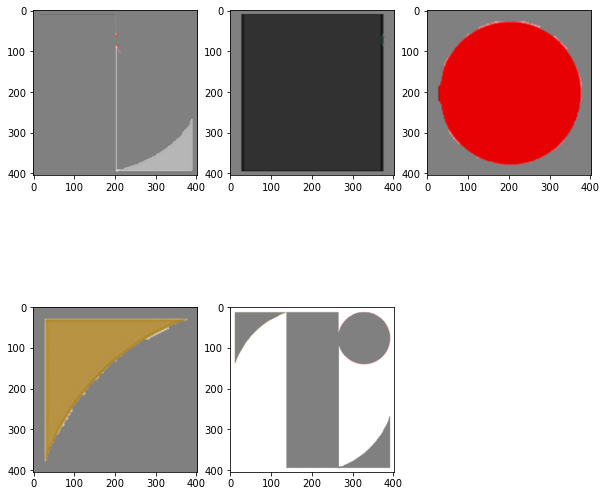

In [165]:
plot_many(ximgs)

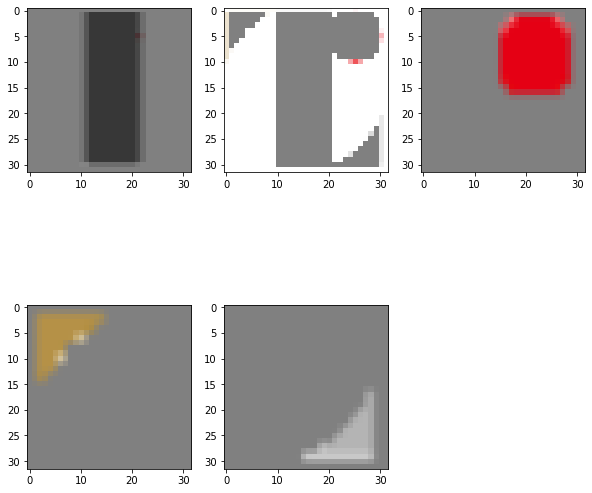

In [167]:
plot_many(yimgs)

100.0


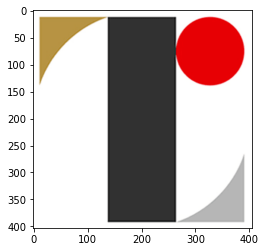

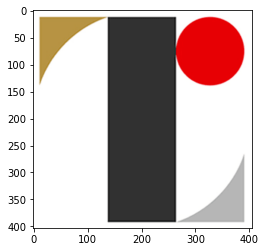

In [152]:
method=make_small_neural_method()#make_small_neural_method()
splitter=segment_agglomerative
# choose the images
cimg1=test_images[-4]
cimg2=test_images[-4]
plt.imshow(cimg1)
plt.figure()
plt.imshow(cimg2)
        
ximgs = splitter(cimg1,rejection=0.001, bg=[128,128,128])
yimgs = splitter(cimg2,rejection=0.001, bg=[128,128,128])
xf=[method['create'](i) for i in ximgs]
yf=[method['create'](i) for i in yimgs]
l=[]
vals = np.array([[method["compare"](i,j,logs=[]) for i in xf] for j in yf])
rows, cols = linear_sum_assignment(-vals)
ret=vals[rows,cols].sum()/len(rows)
print(ret)

In [153]:
vals

array([[100.        ,  22.76259106,  14.84583887,  48.91834611,
         28.58008628],
       [ 22.76259106, 100.        ,  21.0069882 ,  25.97399766,
         22.98156463],
       [ 14.84583887,  21.0069882 , 100.        ,  15.77535121,
         16.36070389],
       [ 48.91834611,  25.97399766,  15.77535121, 100.        ,
         28.02810386],
       [ 28.58008628,  22.98156463,  16.36070389,  28.02810386,
        100.        ]])

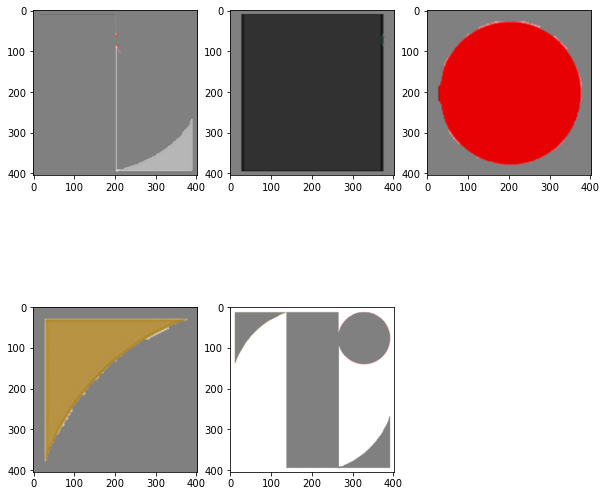

In [154]:
plot_many(ximgs)

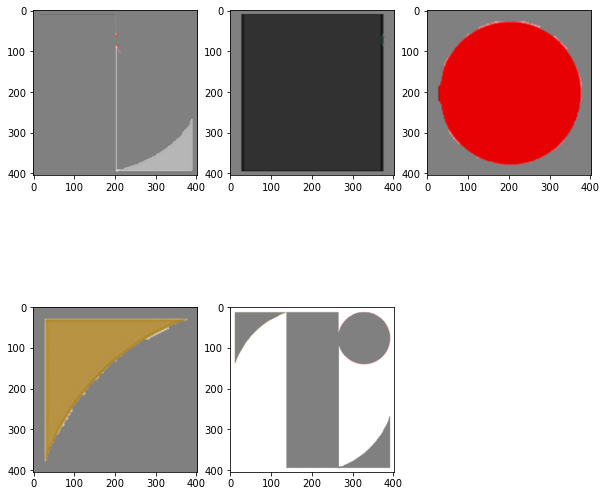

In [155]:
plot_many(yimgs)

In [ ]:
# PIL ImageOps
# Try this this week, see if it works better than median filtering
img = ImageOps.fit(img, (int(rows  scale), int(cols  scale)), Image.ANTIALIAS)

In [ ]:
db1={i:i*5 for i in range(20)}

In [ ]:
a1=[i for i in db1.keys()]
a2 = [i for i in range(15)]
sorted(a1+a2)

In [ ]:
for t in timm_names:
    make_timm(t)

In [ ]:
plt.imshow(test_images[2])

In [ ]:
from scipy.stats import mode
cimg=test_images[1]


bg_stats(cimg)


im7 = safe_translate(cimg)
plt.figure()
plt.imshow(im7)
plt.figure()
plt.imshow(recenter(im7))

In [ ]:

plt.imshow(rotate_safe(cimg, 30))

In [ ]:
logdir

In [ ]:
np.array(running_images)[np.random.choice(len(running_images),20)]

In [ ]:
# how to run your images 2, electric boogaloo
def make_aberimgs(imgs,abers):
    res=[]
    for idx,im in enumerate(imgs):
        for a in abers:
            res+=[[idx,a(im) if a is not None else im, a.__name__ if a is not None else "ab_id"]]
    return res
def run(db,aber_images,logdir="Logs",report_every=10):
    print("starting")
    if not os.path.exists("Logs"):
        os.mkdir("Logs")
    if not os.path.exists("Logs/"+logdir):
        os.mkdir("Logs/"+logdir)
    candidates= [i for i in range(len(aber_images))]
    results={}
    imgs_so_far=0
    for idx,aberimg,abername in aber_images:
        imgs_so_far+=1
        if imgs_so_far % report_every == 0:
            print(imgs_so_far, "img idx ", idx)
        
        start_time=perf_counter()
        xl = db.find(aberimg)
        rank=0
        for hit in xl:
            rank+=1
            if hit[0]==idx:
                break
        duration = perf_counter() - start_time
        results.setdefault("aberration",[]).append(abername)
        results.setdefault("method",[]).append(db.name)
        results.setdefault("preprocess",[]).append(db.preprocessing_name)
        results.setdefault("rank",[]).append(rank)
        results.setdefault("time",[]).append(duration)
    # save everything to file and return the dataframes
    results_pd = pd.DataFrame(data=results)
    log_num = len(glob("Logs/"+logdir+"/*")) + 1
    results_pd.to_csv("Logs/"+logdir+'/results_'+str(log_num)+'.csv', index = None, header=True)
    print("logging")
    return results_pd

def run_all(methods,images,aberrations,pipelines,logdir="Logs",loglist=[]):
    aberimgs=make_aberimgs(images,aberrations)
    for m in methods:
        for p in pipelines:
            db=database(m, images, log=loglist, preprocess=p)
            run(db,aberimgs,logdir=logdir)
    if loglist != []:
        print("we had errors please check the return value")
    return loglist

In [ ]:
image_set_name = "icon100"
logdir = "Logs20211105TEST"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]
running_images=images+test_images
print(len(images))
print("Loading Completed")

#running_methods=[make_timm_method(i,cuda=True) for i in timm_names]+[m() for m in our_methods]
running_methods=[method_split_hungarian(make_small_neural_method(), segment_colors)]
err=run_all(running_methods, running_images,aberrations,processing_pipelines,logdir=logdir)

In [ ]:
err

In [ ]:
running_methods

In [ ]:
abim[1]

In [ ]:
met=[make_timm_method(i,cuda=True) for i in timm_names]

In [ ]:
l=[]
met[0]["create"](running_images[0],log=l)

In [ ]:
l

In [ ]:
logdir = "Logs20211105TEST2"
# Load all the logs into a single dataframe for processing
log_files = glob("Logs/"+logdir+"/*") # these are the logs that we're loading
print(log_files)
joined_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(joined_logs)



In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
print(mets)
split_logs=joined_logs
ncols=1
nrows=(len(mets)//ncols)+1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    joined_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
split_logs=joined_logs[]
ncols=3
nrows=(len(mets)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    joined_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
joined_logs["preprocess"].unique()

In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
split_logs=joined_logs[joined_logs["preprocess"]=='recenter']
ncols=3
nrows=(len(mets)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    split_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
split_logs=joined_logs[joined_logs["preprocess"]=='recenter, reduce, smooth']
ncols=3
nrows=(len(mets)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    split_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
split_logs=joined_logs[joined_logs["preprocess"]=='color_reduce_kmeans']
ncols=3
nrows=(len(mets)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    split_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
split_logs=joined_logs[joined_logs["preprocess"]=='smooth_median']
ncols=3
nrows=(len(mets)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    split_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
print("Ranking")
mets=joined_logs["method"].unique()
split_logs=joined_logs[joined_logs["preprocess"]=='None']
ncols=3
nrows=(len(mets)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
for m,axs in zip(mets,axes.reshape(-1)):
    split_logs[split_logs['method']==m]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
    axs.set_title(m)

In [ ]:
print("Ranking")
for m in joined_logs["method"].unique():
    plt.figure()
    split_logs=joined_logs[joined_logs["method"]==m]
    procs=split_logs["preprocess"].unique()
    ncols=3
    nrows=(len(procs)//ncols)+1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.suptitle(m)
    for p,axs in zip(procs,axes.reshape(-1)):
        split_logs[split_logs['preprocess']==p]['rank'].hist(bins=20, figsize=(10,10), ax=axs)
        axs.set_title(p)

In [ ]:
print("Time")
for m in joined_logs["method"].unique():
    plt.figure()
    split_logs=joined_logs[joined_logs["method"]==m]
    procs=split_logs["preprocess"].unique()
    ncols=3
    nrows=(len(procs)//ncols)+1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.suptitle(m)
    for p,axs in zip(procs,axes.reshape(-1)):
        split_logs[split_logs['preprocess']==p]['time'].hist(bins=20, figsize=(10,10), ax=axs)
        axs.set_title(p)

In [ ]:
len(joined_logs["aberration"].unique())

In [ ]:
l=[]
segs=segment_agglomerative(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)
segs=segment_colors(rimg,log=l,bg=[128,128,255],rejection=0.02)
plot_many([rimg]+segs)
segs=segment_kmeans(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)

In [ ]:
method = make_small_neural_method()

timg=test_images[0]
def remove_diagonal(a):
    return a[~np.eye(a.shape[0],dtype=bool)].reshape(a.shape[0],-1)
def difall(a,b):
    return ((a[np.newaxis,:,:] - b[:,np.newaxis,:])**2).sum(-1)
def method_split_hungarian(method, splitter):
    def create(img, **kwargs):
        try:
            imgs = splitter(img, **kwargs)
            return [method["create"](i, **kwargs) for i in imgs], imgs
        except:
            log(kwargs,{'type':'Error', 'method':'SplitWrapped_'+method["name"], 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            vals = np.array([[method["compare"](i,j,**kwargs) for i in x] for j in y])
            rows, cols = linear_sum_assignment(-vals)
            return rows,cols
            if len(rows==0):
                print("divide by zero incoming")
                return 0
            return vals[rows,cols].sum()/len(rows)
        except:
            log(kwargs,{'type':'Error', 'method':'SplitWrapped_'+method["name"], 'fn':'compare'})
            return 0
    return {"name":'SplitWrapped_'+method["name"], "create":create, "compare":compare}

In [ ]:
method["create"](timg)
splits=segment_colors(timg,log=l,bg=[128,128,128],rejection=0.02)
ss=[method["create"](s) for s in splits]
ss=np.array(ss)

In [ ]:
sss=difall(ss,ss)
sss

In [ ]:
remove_diagonal(sss)

In [ ]:
linear_sum_assignment(sss)

In [ ]:
x=ss
y=np.concatenate((ss,ss))
k=np.array([[method["compare"](i,j) for i in x] for j in y])
linear_sum_assignment(k)

In [ ]:
m2=method_split_hungarian(method, segment_colors)

In [ ]:
d1,i1=m2["create"](test_images[-2])
d2,i2=m2["create"](test_images[-4])
r,c=m2["compare"](d1, d2)
for j,k in zip(c,r):
    plot_many([i1[j],i2[k]])
plot_many(i1)
plot_many(i2)

In [ ]:
image_set_name = "icon100"
logdir = "Logs20211105TEST2"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]
running_images=images+test_images
print(len(images))
print("Loading Completed")

#running_methods=[make_timm_method(i,cuda=True) for i in timm_names]+[m() for m in our_methods]
segs=[segment_color, segment_agglomerative, segment_kmeans]
running_methods=[method_split_hungarian(make_small_neural_method(), segment_colors) for s in segs]
err=run_all(running_methods, running_images,aberrations,processing_pipelines,logdir=logdir)

In [ ]:
image_set_name = "icon100"
logdir = "Logs20211105TEST3"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]
running_images=images+test_images
print(len(images))
print("Loading Completed")

#running_methods=[make_timm_method(i,cuda=True) for i in timm_names]+[m() for m in our_methods]
segs=[segment_color, segment_agglomerative, segment_kmeans]
running_methods=[method_split_hungarian(make_small_neural_method(), segment_colors) for s in segs]
err=run_all(running_methods, running_images,aberrations,processing_pipelines,logdir=logdir)

In [ ]:
from PIL import Image, ImageDraw
def draw_poly(dc,poly, scale=1, **kwargs):
    coords = (poly*scale).astype(int)
    dc.polygon([tuple(i) for i in coords],**kwargs)
polys=[# wedge
       [[0,0], [0,0.5], [1,1]],
       # circle
       [[0.5+cos(x*6.14/20)/2,0.5+sin(x*6.14/20)/2] for x in range(20)],
       # randomly perturbed circle
       [[0.5+cos(x*6.14/20)*np.random.uniform(0.2,1.0)/2,0.5+sin(x*6.14/20)*np.random.uniform(0.2,1.0)/2] for x in range(20)],
       # squished circle
       [[0.43889485, 1.01199527],
           [0.50584096, 1.03654858],
           [0.56339267, 1.03823472],
           [0.60616826, 1.01689601],
           [0.63016773, 0.97452786],
           [0.63314687, 0.91509216],
           [0.61482709, 0.8441468 ],
           [0.5769215 , 0.76832597],
           [0.52297469, 0.69471975],
           [0.45803129, 0.63021113],
           [0.38816421, 0.58083239],
           [0.31990682, 0.551201  ],
           [0.25964192, 0.5440878 ],
           [0.21300497, 0.56015797],
           [0.18435702, 0.59790877],
           [0.17637698, 0.65381007],
           [0.18981107, 0.72263449],
           [0.22340306, 0.79794618],
           [0.27401172, 0.87270266],
           [0.33690458, 0.93991338]],
      # star thing
      [[0.41807544, 0.87534801],
       [0.46415562, 0.98536887],
       [0.53947724, 0.94539019],
       [0.59524502, 1.0083861 ],
       [0.51879522, 0.89930979],
       [0.48691866, 0.83740086],
       [0.6054967 , 0.86355202],
       [0.58552607, 0.83129026],
       [0.41381491, 0.66344889],
       [0.4658818 , 0.68867009],
       [0.38576388, 0.62978679],
       [0.32330981, 0.55634607],
       [0.32094132, 0.70405591],
       [0.32852805, 0.70085152],
       [0.3041241 , 0.72073516],
       [0.28525641, 0.71508238],
       [0.22339421, 0.71973661],
       [0.35555229, 0.82499804],
       [0.33906122, 0.81146125],
       [0.38112243, 0.83347015]]]
polys=[np.array(p) for p in polys]
colors=[[255,255,255], #white
        [255,0,0], #red
        [0,255,0], #green
        [0,0,255], #blue
        [102,0,204], #purple
        [128,128,128], #gray
        [255,153,153], #pink
        [153,153,0], #puke green
        [102,102,0], #camo green
        [255,128,0], #orange
        [204,255,153], #light green
        [255,255,51], #lemon yellow
        [255,255,0], #yellow
       ]
for poly in polys:
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    plt.figure()
    plt.imshow(im)

In [ ]:

from math import sin, cos
def draw_and_show_poly(poly, scale=32):
    im=Image.new('RGB', (scale,scale))
    dc = ImageDraw.Draw(im)
    draw_poly(dc,poly,scale=scale,fill="white")
    plt.figure()
    plt.imshow(im)
def create_transform_random():
    mat=np.random.uniform(0,1,(3,3))*0.5
    mat[2,0]=0
    mat[2,1]=0
    mat[2,2]=1
    return mat

def create_transform_identity():
    return np.eye(3,3)

def create_transform_informed(scale=(1.0,1.0), rotation=(0.0,0.0), symmetry=False, transform=(0.0,0.0), heat=0):
    res=np.eye(3)
    scaleness=np.eye(3)*np.random.uniform(*scale)
    res=res.dot(scaleness)
    rotateness=np.random.uniform(*rotation)
    if symmetry:
        rotateness += np.random.choice([0,.25,.5,.75])
    rotatarr=np.array([[ cos(rotateness*6.28), sin(rotateness*6.28), 0],
                         [-sin(rotateness*6.28), cos(rotateness*6.28), 0],
                         [0,0,1]])
    res=res.dot(rotatarr)
    hotness=create_transform_random()*heat
    res=res+(hotness-heat/2)
    res[0,2]=np.random.uniform(*transform)
    res[1,2]=np.random.uniform(*transform)
    return res
    
def transform(tform, points):
    res = np.concatenate([points,np.ones([points.shape[0],1])], axis=1)
    return res.dot(tform.transpose())[:,:2]

def render(dc,scale,tforms, shapes,colors):
    for t,sh,c in zip(tforms, shapes,colors):
        draw_poly(dc,transform(t,sh),scale=scale, fill=c)
        
def render_image(scale,tforms,shapes,colors):
    im = Image.new('RGB', (scale,scale))
    dc = ImageDraw.Draw(im)
    render(dc,scale,tforms,shapes,colors)
    return im
        
def create_random_icon(shapes, colors):
    structure = [create_transform_identity(),
                create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2),
                create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2),]
    colors = [tuple(colors[np.random.choice(len(colors))]),
              tuple(colors[np.random.choice(len(colors))]),
              tuple(colors[np.random.choice(len(colors))])]
    s = [shapes[np.random.choice(len(shapes))],
         shapes[np.random.choice(len(shapes))],
         shapes[np.random.choice(len(shapes))]]
    return structure,colors,s


def make_icon3(shapes, colors):
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    shape1 = shapes[np.random.choice(len(shapes))]
    shape2 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_identity()
    shape2=transform(tform,shape2)
    draw_poly(dc,shape2,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    return im

def make_icon(shapes, colors):
    im = Image.new('RGB', (32,32))
    dc = ImageDraw.Draw(im)
    shape1 = shapes[np.random.choice(len(shapes))]
    shape2 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2)
    shape2=transform(tform,shape2)
    shape3 = shapes[np.random.choice(len(shapes))]
    tform=create_transform_informed(scale=(0.5,1.2), rotation=(0.0,1.0), symmetry=False, heat=0.2)
    shape3=transform(tform,shape3)
    draw_poly(dc,shape1,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    draw_poly(dc,shape2,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    draw_poly(dc,shape3,scale=32,fill=tuple(colors[np.random.choice(len(colors))]))
    return im

def make_icon2(scale,shapes, colors):
    structure,colors,s=create_random_icon(shapes,colors)
    return render_image(scale,structure,s,colors)
for i in range(5):
    plt.imshow(make_icon2(512,polys,colors))
    plt.figure()

In [ ]:
synthetic_image_data = [create_random_icon(polys,colors) for _ in range(1000)]
print(len(synthetic_image_data))
low_res_renders = [render_image(32,i[0],i[2],i[1]) for i in synthetic_image_data]
high_res_renders = [render_image(512,i[0],i[2],i[1]) for i in synthetic_image_data]

In [ ]:
low_res_renders = [render_image(32,i[0],i[2],i[1]) for i in synthetic_image_data]
high_res_renders = [render_image(512,i[0],i[2],i[1]) for i in synthetic_image_data]

In [ ]:
for i in high_res_renders[:10]:
    plt.imshow(i)
    plt.figure()

In [ ]:
image_set_name = "synth100"
logdir = "Logs20211211TEST"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images = high_res_renders[:100]
images = [np.array(i) for i in images]

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]
running_images=images+test_images
print(len(images))
print("Loading Completed")

#running_methods=[make_timm_method(i,cuda=True) for i in timm_names]+[m() for m in our_methods]
running_methods=[method_split_hungarian(make_small_neural_method(), segment_colors)]
err=run_all(running_methods, running_images,aberrations,processing_pipelines,logdir=logdir)

In [ ]:
err